## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете

**Пути к директориям и файлам**

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import pickle
import random
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
#import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [3]:
TRAIN_DATASET_PATH = 'C:\data_train.csv'
TEST_DATASET_PATH = 'C:\data_test.csv'
OUT_DATASET_PATH = r'C:\answers_test.csv'

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

**Загрузка данных**

In [6]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


In [7]:
df_train.shape

(831653, 5)

In [8]:
df_train.iloc[0]

Unnamed: 0    0.000000e+00
id            5.409680e+05
vas_id        8.000000e+00
buy_time      1.537132e+09
target        0.000000e+00
Name: 0, dtype: float64

Обзор данных

Обзор целевой переменной

In [9]:
df_train['target'].value_counts()

0.0    771467
1.0     60186
Name: target, dtype: int64

Обзор тестового набора

In [10]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.shape

(71231, 4)

In [11]:
df = df_train.merge(df_test, left_on='id', right_on='id')
df.shape

(4228, 8)

Видно, что пересечение только в 4000 строк. Значит 4228 из 71231 пользователей совпадают в тренировочном и тестовом наборах, а остальные - новые. Значит id можно выбросить из модели.

In [12]:
df_train.describe()

,Unnamed: 0,id,vas_id,buy_time,target
count,831653.000000,8.316530e+05,831653.000000,8.316530e+05,831653.000000
mean,415826.000000,2.158304e+06,2.686185,1.538937e+09,0.072369
std,240077.686048,1.257907e+06,1.952034,5.019053e+06,0.259098
min,0.000000,2.000000e+00,1.000000,1.531084e+09,0.000000
25%,207913.000000,1.067319e+06,1.000000,1.534108e+09,0.000000
50%,415826.000000,2.144574e+06,2.000000,1.538341e+09,0.000000
75%,623739.000000,3.244254e+06,4.000000,1.544389e+09,0.000000
max,831652.000000,4.362694e+06,9.000000,1.546204e+09,1.000000


Обработка данных

vas_id - категориальная переменная и значит надо преобразовать в форму Dummies переменной

In [46]:
df_train['VAS_ID_IS_1'] = df_train['vas_id'].map({1:'1',2:'0',3:'0',4:'0',5:'0',6:'0',7:'0',8:'0',9:'0'}).astype(int)
df_train['VAS_ID_IS_2'] = df_train['vas_id'].map({1:'0',2:'1',3:'0',4:'0',5:'0',6:'0',7:'0',8:'0',9:'0'}).astype(int)
df_train['VAS_ID_IS_3'] = df_train['vas_id'].map({1:'0',2:'0',3:'1',4:'0',5:'0',6:'0',7:'0',8:'0',9:'0'}).astype(int)
df_train['VAS_ID_IS_4'] = df_train['vas_id'].map({1:'0',2:'0',3:'0',4:'1',5:'0',6:'0',7:'0',8:'0',9:'0'}).astype(int)
df_train['VAS_ID_IS_5'] = df_train['vas_id'].map({1:'0',2:'0',3:'0',4:'0',5:'1',6:'0',7:'0',8:'0',9:'0'}).astype(int)
df_train['VAS_ID_IS_6'] = df_train['vas_id'].map({1:'0',2:'0',3:'0',4:'0',5:'0',6:'1',7:'0',8:'0',9:'0'}).astype(int)
df_train['VAS_ID_IS_7'] = df_train['vas_id'].map({1:'0',2:'0',3:'0',4:'0',5:'0',6:'0',7:'1',8:'0',9:'0'}).astype(int)
df_train['VAS_ID_IS_8'] = df_train['vas_id'].map({1:'0',2:'0',3:'0',4:'0',5:'0',6:'0',7:'0',8:'1',9:'0'}).astype(int)
df_train['VAS_ID_IS_9'] = df_train['vas_id'].map({1:'0',2:'0',3:'0',4:'0',5:'0',6:'0',7:'0',8:'0',9:'1'}).astype(int)

Добавим новые признак "месяц" и посмотрим на корреляции с целевой переменной.  

In [47]:
from datetime import datetime
df_train['date'] = list(map(datetime.fromtimestamp,df_train['buy_time']))
df_train['month'] = df_train['date'].apply(lambda x: x.timetuple()[1])
df_train['days'] = df_train['date'].apply(lambda x: x.timetuple()[7])

Обработка пропусков

In [48]:
len(df_train) - df_train.count()

Unnamed: 0     0
id             0
vas_id         0
buy_time       0
target         0
date           0
month          0
days           0
VAS_ID_IS_1    0
VAS_ID_IS_2    0
VAS_ID_IS_3    0
VAS_ID_IS_4    0
VAS_ID_IS_5    0
VAS_ID_IS_6    0
VAS_ID_IS_7    0
VAS_ID_IS_8    0
VAS_ID_IS_9    0
dtype: int64

In [49]:
TARGET_NAME = 'target'
df = pd.read_csv(TRAIN_DATASET_PATH)
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

Корреляция с базовыми признаками

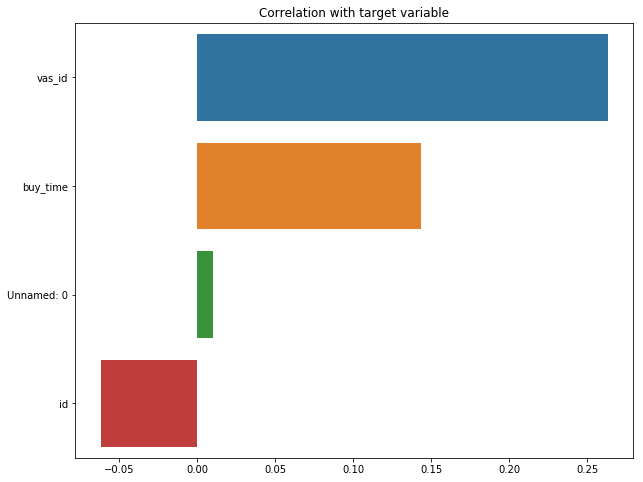

In [50]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

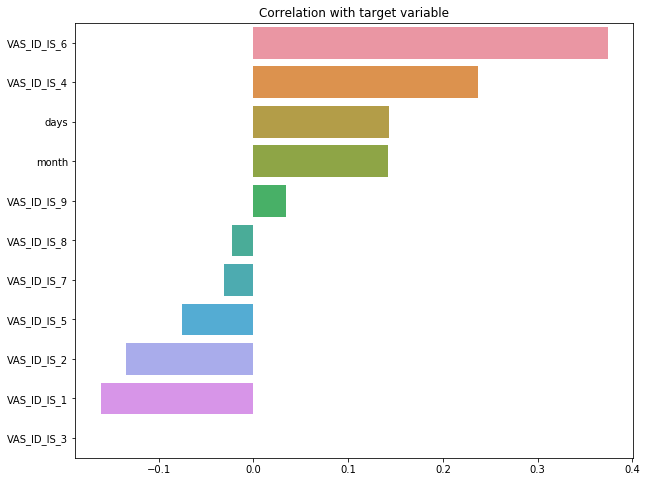

In [51]:
corr_with_target = df_train[NEW_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Видно, что VAS_ID_IS_3 слабо коррелирует с целевой переменной и его можно отбросить.

In [52]:
import warnings
warnings.simplefilter('ignore')

Отбор признаков

In [53]:
NUMERIC_FEATURE_NAMES = ['days']
FEATURE_NAMES_SELECTED = NUMERIC_FEATURE_NAMES + ['VAS_ID_IS_1','VAS_ID_IS_2','VAS_ID_IS_4','VAS_ID_IS_5','VAS_ID_IS_6','VAS_ID_IS_7','VAS_ID_IS_8','VAS_ID_IS_9']

Нормализация данных

In [54]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

df = df_norm.copy()

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [55]:
X = df[FEATURE_NAMES_SELECTED]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

In [56]:
TARGET_NAME in FEATURE_NAMES_SELECTED

False

In [57]:
len(X_test.columns)

9

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [58]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0.0    578781
1.0    539496
Name: target, dtype: int64

In [59]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

Базовая модель без машинного обучения

Вероятности подключения услуг можно посчитать статистическим методом без машинного обучения. Для этого поделим кол-во принятых предложений услуги на общее кол-во предложений этой услуги. Можно сделать такой подсчет для каждой услуги.

In [60]:
def get_statistic_propability(df, filter_id, target):
    df_filtered = df[df['vas_id'] == filter_id] 
    if len(df_filtered) != 0:
        return sum(df_filtered[target]) / len(df_filtered)
    else:
        return 0

In [70]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
propability_1 = get_statistic_propability(df_train, 1, 'target')
propability_2 = get_statistic_propability(df_train, 2, 'target')
propability_3 = get_statistic_propability(df_train, 3, 'target')
propability_4 = get_statistic_propability(df_train, 4, 'target')
propability_5 = get_statistic_propability(df_train, 5, 'target')
propability_6 = get_statistic_propability(df_train, 6, 'target')
propability_7 = get_statistic_propability(df_train, 7, 'target')
propability_8 = get_statistic_propability(df_train, 8, 'target')
propability_9 = get_statistic_propability(df_train, 9, 'target')

print('P1 = ',propability_1)
print('P2 = ',propability_2)
print('P3 = ',propability_3)
print('P4 = ',propability_4)
print('P5 = ',propability_5)
print('P6 = ',propability_6)
print('P7 = ',propability_7)
print('P8 = ',propability_8)
print('P9 = ',propability_9)

P1 =  0.01826065930523092
P2 =  0.019226067613875474
P3 =  0
P4 =  0.25380148327813795
P5 =  0.017983738109156613
P6 =  0.4268288468848267
P7 =  0.01380248833592535
P8 =  0.02599250936329588
P9 =  0.1834795321637427


Все вероятности меньше 0.5 (P < 0.5) => target = 0

In [71]:
y_train_pred = np.zeros(len(y_train))
y_test_pred = np.zeros(len(y_test))
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.52      1.00      0.68    578781
         1.0       0.00      0.00      0.00    539496

   micro avg       0.52      0.52      0.52   1118277
   macro avg       0.26      0.50      0.34   1118277
weighted avg       0.27      0.52      0.35   1118277

TEST

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    192686
         1.0       0.00      0.00      0.00     15228

   micro avg       0.93      0.93      0.93    207914
   macro avg       0.46      0.50      0.48    207914
weighted avg       0.86      0.93      0.89    207914

CONFUSION MATRIX

col_0      0.0
target        
0.0     192686
1.0      15228


**Логистическая регрессия**

In [72]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84    578781
         1.0       0.85      0.78      0.81    539496

   micro avg       0.83      0.83      0.83   1118277
   macro avg       0.83      0.83      0.83   1118277
weighted avg       0.83      0.83      0.83   1118277

TEST

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    192686
         1.0       0.32      0.79      0.46     15228

   micro avg       0.86      0.86      0.86    207914
   macro avg       0.65      0.83      0.69    207914
weighted avg       0.93      0.86      0.89    207914

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     167100  25586
1.0       3140  12088


Исходя из сравнения данных TRAIN и TEST переобучение произошло. 

попробуем случайный лес (RandomForest).

RF

In [43]:
from sklearn.ensemble import RandomForestClassifier as RF

In [44]:
clf = RF(max_depth=18,n_estimators=40,max_features=3,random_state=100)

In [46]:
parameters = [{'n_estimators': [20,40,50],'max_features': np.arange(3,5),'max_depth': [4,3,2,1]}]

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
clf = GridSearchCV(estimator=RF(random_state=100),param_grid=parameters,scoring='f1',cv=3)

In [49]:
clf.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=100, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [20, 40, 50], 'max_features': array([3, 4]), 'max_depth': [4, 3, 2, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [50]:
clf.best_params_

{'max_depth': 4, 'max_features': 4, 'n_estimators': 40}

In [51]:
from sklearn.metrics import f1_score as f1 

Борьба с переобучением

In [52]:
for i in range(4,0,-1):
    print(f'max_depth={i}')
    clf = RF(max_depth=i, n_estimators=40, max_features=4, random_state=100)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_train)
    print(f1(y_train,pred, average='macro'))
    pred_valid = clf.predict(X_test)
    print(f1(y_test,pred_valid, average='macro'))
    print()

max_depth=4
0.8874543115317362
0.713724097128166

max_depth=3
0.8513713968897867
0.7013317351461967

max_depth=2
0.8226780692211402
0.6916827469164588

max_depth=1
0.6996868273573926
0.5478238167139852



In [61]:
clf = RF(max_depth=4,n_estimators=40,max_features=4,random_state=100)

In [65]:
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=100, verbose=0, warm_start=False)

In [66]:
pred = clf.predict(X_train)

In [67]:
f1(y_train, pred, average='macro')

0.8874543115317362

In [68]:
pred_valid = clf.predict(X_test)

In [69]:
pred_valid

array([0., 0., 0., ..., 0., 1., 0.])

In [70]:
f1(y_test,pred_valid, average='macro')

0.713724097128166

In [71]:
get_classification_report(y_train, pred, y_test, pred_valid)

TRAIN

              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89    578781
         1.0       0.86      0.91      0.89    539496

   micro avg       0.89      0.89      0.89   1118277
   macro avg       0.89      0.89      0.89   1118277
weighted avg       0.89      0.89      0.89   1118277

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    192686
         1.0       0.35      0.91      0.50     15228

   micro avg       0.87      0.87      0.87    207914
   macro avg       0.67      0.89      0.71    207914
weighted avg       0.94      0.87      0.89    207914

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     166637  26049
1.0       1344  13884


In [72]:
pred_valid_proba = clf.predict_proba(X_test)

In [73]:
pred_valid_proba

array([[0.72029462, 0.27970538],
       [0.86870811, 0.13129189],
       [0.82527688, 0.17472312],
       ...,
       [0.88748648, 0.11251352],
       [0.10597618, 0.89402382],
       [0.71694115, 0.28305885]])

Вывод: модель RandomForest показала лучший результат и будем использовать эту модель как финальную.

In [74]:
final_model = clf

### Подготовка тестовых данных<a class="anchor" id="target_balancing"></a>

In [75]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [76]:
df = df_test
df['VAS_ID_IS_1'] = df['vas_id'].map({1:'1',2:'0',3:'0',4:'0',5:'0',6:'0',7:'0',8:'0',9:'0'}).astype(int)
df['VAS_ID_IS_2'] = df['vas_id'].map({1:'0',2:'1',3:'0',4:'0',5:'0',6:'0',7:'0',8:'0',9:'0'}).astype(int)
df['VAS_ID_IS_3'] = df['vas_id'].map({1:'0',2:'0',3:'1',4:'0',5:'0',6:'0',7:'0',8:'0',9:'0'}).astype(int)
df['VAS_ID_IS_4'] = df['vas_id'].map({1:'0',2:'0',3:'0',4:'1',5:'0',6:'0',7:'0',8:'0',9:'0'}).astype(int)
df['VAS_ID_IS_5'] = df['vas_id'].map({1:'0',2:'0',3:'0',4:'0',5:'1',6:'0',7:'0',8:'0',9:'0'}).astype(int)
df['VAS_ID_IS_6'] = df['vas_id'].map({1:'0',2:'0',3:'0',4:'0',5:'0',6:'1',7:'0',8:'0',9:'0'}).astype(int)
df['VAS_ID_IS_7'] = df['vas_id'].map({1:'0',2:'0',3:'0',4:'0',5:'0',6:'0',7:'1',8:'0',9:'0'}).astype(int)
df['VAS_ID_IS_8'] = df['vas_id'].map({1:'0',2:'0',3:'0',4:'0',5:'0',6:'0',7:'0',8:'1',9:'0'}).astype(int)
df['VAS_ID_IS_9'] = df['vas_id'].map({1:'0',2:'0',3:'0',4:'0',5:'0',6:'0',7:'0',8:'0',9:'1'}).astype(int)


In [77]:
from datetime import datetime
df['date'] = list(map(datetime.fromtimestamp,df['buy_time']))
df['days'] = df['date'].apply(lambda x: x.timetuple()[7])

In [78]:
df.head()

,Unnamed: 0,id,vas_id,buy_time,VAS_ID_IS_1,VAS_ID_IS_2,VAS_ID_IS_3,VAS_ID_IS_4,VAS_ID_IS_5,VAS_ID_IS_6,VAS_ID_IS_7,VAS_ID_IS_8,VAS_ID_IS_9,date,days
0,0,3130519,2.0,1548018000,0,1,0,0,0,0,0,0,0,2019-01-21,21
1,1,2000860,4.0,1548018000,0,0,0,1,0,0,0,0,0,2019-01-21,21
2,2,1099444,2.0,1546808400,0,1,0,0,0,0,0,0,0,2019-01-07,7
3,3,1343255,5.0,1547413200,0,0,0,0,1,0,0,0,0,2019-01-14,14
4,4,1277040,2.0,1546808400,0,1,0,0,0,0,0,0,0,2019-01-07,7


In [79]:
NUMERIC_FEATURE_NAMES = ['days']
FEATURE_NAMES_SELECTED = NUMERIC_FEATURE_NAMES + ['VAS_ID_IS_1','VAS_ID_IS_2','VAS_ID_IS_4','VAS_ID_IS_5','VAS_ID_IS_6','VAS_ID_IS_7','VAS_ID_IS_8','VAS_ID_IS_9']

Нормализация

In [80]:
scaler = StandardScaler()

df_norm = df_test.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

df = df_norm.copy()

In [81]:
len(df)

71231

In [82]:
len(FEATURE_NAMES_SELECTED)

9

In [83]:
X_test = df[FEATURE_NAMES_SELECTED]
len(X_test)

71231

In [84]:
len(X_test.columns)

9

In [85]:
len(X_test)

71231

In [86]:
y_test_pred = final_model.predict(X_test)

In [87]:
y_test_pred

array([0., 1., 0., ..., 0., 0., 0.])

In [88]:
y_test_pred_proba = final_model.predict_proba(X_test)

In [89]:
y_test_pred_proba[:,1]

array([0.10557861, 0.70056127, 0.18169223, ..., 0.10557861, 0.10557861,
       0.10557861])

In [90]:
df = pd.read_csv(TEST_DATASET_PATH)

In [91]:
df['date'] = list(map(datetime.fromtimestamp,df['buy_time']))

In [92]:
df['msisdn'] = df['id']
FEATURE_NAMES_SELECTED =['date','msisdn','vas_id']
df = df[FEATURE_NAMES_SELECTED]
df.head()

,date,msisdn,vas_id
0,2019-01-21,3130519,2.0
1,2019-01-21,2000860,4.0
2,2019-01-07,1099444,2.0
3,2019-01-14,1343255,5.0
4,2019-01-07,1277040,2.0


In [93]:
df[TARGET_NAME] = y_test_pred_proba[:,1]

In [94]:
len(df)

71231

Сохранение результирующих данных в CSV-формат

In [95]:
df.to_csv(OUT_DATASET_PATH,index=None)

Сохранение модели в pickle формат

In [96]:
filename = 'final_model.pkl'
pickle.dump(final_model, open(filename, 'wb'))